In [11]:
#!pip install biopython
import sys, os, copy, pprint, glob, random
from importlib import reload
import pathlib, importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import pyfastx

In [2]:
import utils.BitOperations as B
import utils.ProbeChoice as PC

## Import UniProt:  
Download One protein per gene
https://www.uniprot.org/proteomes/UP000005640

In [3]:
huprot_path="data/UP000005640_9606.fasta"
fa_file = pyfastx.Fasta(huprot_path)
fa_file

<Fasta> data/UP000005640_9606.fasta contains 20605 sequences

## N-mer Generation/Characterization:                         

In [25]:
# Base substitution Map
SEQ = 'HKRDESTNQAVLIMFYWPGC'
TSEQ = 'HppnntttaaaaaMFYWPGC'
makeTran = str.maketrans(SEQ,TSEQ)

#usage sComp = sSeq.translate(makeTran)

In [74]:
NMER_SZ=3

probe_bitmap=PC.BitMap()
pLst=[]
max_r=1000;i=0
for seq in fa_file:
    if len(seq.seq)<100:continue
    i+=1
    name=seq.name;
    prefix, acc=name.split('|')[0:2]
    if prefix=='tr':continue
    #aa_seq=(seq.seq).translate(makeTran)
    aa_seq=seq.seq
    pLst.append(PC.Peptide(aa_seq, name, nmer_sz=NMER_SZ))
    probe_bitmap.process_peptide(pLst[-1])
    if i >max_r:break
all_peptide_counts=[p[1] for p in list(probe_bitmap.d.items())]

probe_bitmap.order(count_limit=0)
probe_bitmap.display()

BitMap: 7988 
LLL	637
SSS	521
PPP	484
AAA	454
EEE	443
SSL	387
LPP	335
SLL	334
LEE	330
LLA	329


In [75]:
#select proteins by size; Compute n-mer embedding
protLst=[]
for p in pLst:
    if 100<len(p.seq)<800:
        p.make_bitfield(probe_bitmap)
        protLst.append(p)
        if random.random()<0.001:p.display()
print(len(protLst))

acc: A6NK97 seq_len: 555, bf_occupancy: 507
acc: A6NKW6 seq_len: 160, bf_occupancy: 153
acc: A6PVS8 seq_len: 624, bf_occupancy: 565
725


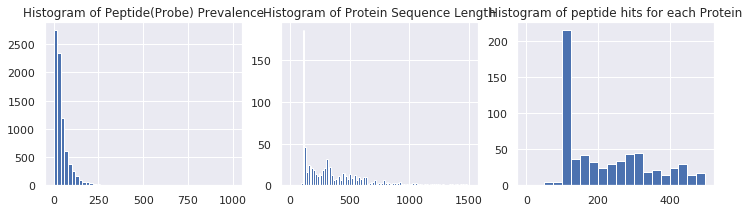

In [76]:
plt.figure(figsize=(12, 3))

axs=plt.subplot(131)
plt.title("Histogram of Peptide(Probe) Prevalence")
axs.hist(all_peptide_counts, bins=50, range=(0,1000))

axs=plt.subplot(132)
plt.title("Histogram of Protein Sequence Length")
axs.hist([len(p.seq) for p in pLst], bins=100, range=(0,1500))

axs=plt.subplot(133)
plt.title("Histogram of peptide hits for each Protein")
axs.hist([p.bf.count() for p in protLst], bins=20, range=(0,500))
plt.show()

In [77]:
#Make Protein Embedding List: ProtLst
iLst=[];plotLst=[]
protLst.sort(key=lambda x:-x.bf.count())
for p in protLst:
    row=[int(x) for x in list(p.bf.bin_str())]
    if random.random()<0.001:print(p.label, p.bf.array_sz, p.bf.max, len(row), p.bf.count(), len(p.bf.export_bit_idxLst()))
    iLst.append([p.label] + row)
    plotLst.append(row)
bf_img=np.array(iLst)
print(len(iLst))
img = Image.fromarray(bf_img, mode='1')
img.save('bf_img.jpg', format='JPEG', subsampling=0, quality=100)
LL=[N for N in probe_bitmap.Lst]
extra_spacers=len(row)-len(LL)
LL=['seq_name']+LL+list(range(extra_spacers))
df = pd.DataFrame(iLst, columns=LL)
df.to_csv('hitmap.csv')

sp|A6NK75|ZNF98_HUMAN 125 7989 8000 317 317
725


[Text(30.5,0.5,'Protein_subset'), Text(0.5,12.5,'Peptide n-mers')]

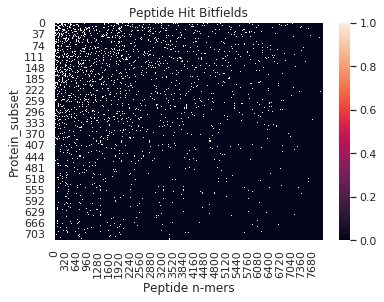

In [78]:
import seaborn as sns; sns.set()

plt.show()
num_probes=len(probe_bitmap.Lst)
ax = sns.heatmap([p[:num_probes] for p in plotLst])
plt.title("Peptide Hit Bitfields")
ax.set(xlabel='Peptide n-mers', ylabel='Protein_subset')

[Text(30.5,0.5,'Protein_idx'), Text(0.5,12.5,'Protein_idx')]

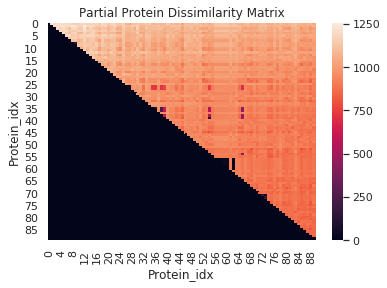

In [79]:
#Protein dissimilarityMatrix
NumSeqs=90;pairLst=[]
DM=[[0 for x in range(NumSeqs)] for x in range(NumSeqs)]
for i in range(NumSeqs):
    a=protLst[i]
    for j in range(i, NumSeqs, 1):
        b=protLst[j]
        d=(a.bf)^(b.bf)
        DM[i][j]=d.count()
        pairLst.append([i,j,DM[i][j]])
pairLst.sort(key=lambda x:x[-1])
plt.show()
ax = sns.heatmap(DM)
plt.title("Partial Protein Dissimilarity Matrix")
ax.set(xlabel='Protein_idx', ylabel='Protein_idx') 

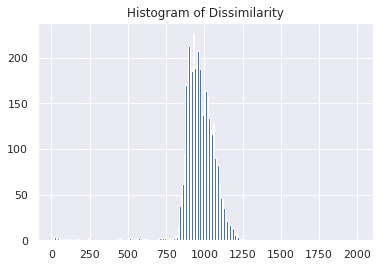

In [84]:
fig, axs = plt.subplots(tight_layout=False)
plt.title("Histogram of Dissimilarity")
yo=axs.hist([p[-1] for p in pairLst], bins=200, range=(10,2000))

## Probe Choice

In [33]:
def chooseMostPrevalentProbe(probeLst, probe_bitmap, randomize=True):
    number_Lst=[probe_bitmap.d[probe] for probe in probeLst]
    if randomize:
        n_sum=sum(number_Lst)
        r=int(random.random()*n_sum)
        for i in range(len(number_Lst)):
            r-=number_Lst[i]
            if r<0:break
        return probeLst[i]
    else:
        return probeLst[np.argmax(number_Lst)]

In [ ]:
RND_CHOICE=False;NUM_RANKS=12


probeLst=[PC.chooseMostPrevalentProbe(probe_bitmap.Lst, probe_bitmap, randomize=RND_CHOICE)]
cycleLst=[];cycleLL=['cycle', 'num_clusters', 'num_choice_possibilities', 'probeSet']
discernible_clusters=0;clusters_to_discern=len(protLst)
cycle=0;previous_discernible_clusters=0
while discernible_clusters < clusters_to_discern:
    cycle+=1
    choiceLst=PC.ChoiceCycle_mp(protLst, probe_bitmap, probeLst, choice_window=0, num_ranks=NUM_RANKS)
    prLst=[c[1] for c in choiceLst]
    probe=PC.chooseMostPrevalentProbe(prLst, probe_bitmap, randomize=RND_CHOICE)
    choice_idx=prLst.index(probe)
    #Choose first of equals You can also choose randomly or choose from within choice_window range
    num_clusters,probe =choiceLst[choice_idx]
    if num_clusters>discernible_clusters:
        probeLst.append(probe)
        cycleLst.append([cycle, num_clusters, len(choiceLst), '|'.join(probeLst)])
        discernible_clusters=num_clusters
        print(cycle, num_clusters, len(choiceLst), probe)
    else:
        print('No more optimization is possible')
        break
    
print(probeLst)

In [ ]:
out_dir="./"
clst=[[r[0], r[1], len(r[3].split('|'))] for r in cycleLst]
df=pd.DataFrame(clst, columns=['cycle',
                                'num_clusters', 
                                'num_probes'])
df.to_csv(out_dir+'choice_cycle_run.csv')

plt.plot(list(range(len(clst))), [c[1] for c in clst])
plt.title("Resolution by Choice Cycle")

plt.xlabel('Cycle/Probes Chosen')
plt.ylabel('Resolution (clusters)')
plt.show()

In [ ]:
#ProbeSet Protein dissimilarityMatrix
probeset_bitfield = PC.GenerateProbeSetBF(probeLst, probe_bitmap)
NumSeqs=90;pairLst=[]
DM=[[0 for x in range(NumSeqs)] for x in range(NumSeqs)]
for i in range(NumSeqs):
    a=protLst[i]
    for j in range(i, NumSeqs, 1):
        b=protLst[j]
        d=(a.bf&probeset_bitfield)^(b.bf&probeset_bitfield)
        DM[i][j]=d.count()
        pairLst.append([i,j,DM[i][j]])
pairLst.sort(key=lambda x:x[-1])
plt.show()
ax = sns.heatmap(DM)
plt.title("Partial ProbeSet Protein Dissimilarity Matrix")
ax.set(xlabel='Protein_idx', ylabel='Protein_idx') 

In [ ]:
fig, axs = plt.subplots(tight_layout=False)
plt.title("Histogram of ProbeSet Derived Dissimilarity")
yo=axs.hist([p[-1] for p in pairLst], bins=100, range=(0,100))